# Single compartmental model - passive soma

We define and then numerically simulate a single compartment, made of a passive membrane equipped by only *leak* (i.e., non voltage-dependent) ion channels. A current-clamp microelectrode, stimulating intracellularly by a step-wise DC waveform of amplitude $I_{stim}(t)$ is also *inserted* inside the membrane and used to stimulate the compartment.

The membrane potential $V$ evolves in time according to the usual ordinary differential equation:

$C \frac{dV(t)}{dt}\ = \ G_{leak} (E_{leak} - V) + I_{stim}$

The initial condition is also provided

$V(0) = -70 mV$

In [1]:
#@title NEURON install (launch only once)
# Note: Google Colab gives you access to an "instance".
# This is a virtual machine ("container" would be more correct) that runs
# Linux with already a Python installation.
!pip install neuron

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 11.8 MB/s eta 0:00:00


In [2]:
#@title NEURON and other Python Libraries import
from neuron import n
import matplotlib.pyplot as plt

# run standard library for high-level simulation control functions
n.load_file("stdrun.hoc")

# Only in a jupyter notebook / jupyter lab environment
%matplotlib inline

In [3]:
#@title Define and create the model
# create model
soma  = n.Section(name="soma")
soma.L  = 10            # length µm
soma.diam = 10          # diameter µm
soma.insert('pas')      # add passive properties
soma.g_pas = 1/10000    # set the specific membrane
                        # resistance to 10000 ohm*cm^2
# current clamp
stim = n.IClamp(soma(0.5))
stim.delay = 20         # start of the current injection (ms)
stim.dur  = 100         # duration (ms)
stim.amp  = 0.01        # amplitude (nA)

# record voltage at the soma, the injected current, and the time
soma_v = n.Vector()
soma_v.record(soma(0.5)._ref_v)

stim_current = n.Vector()
stim_current.record(stim._ref_i)

t = n.Vector()
t.record(n._ref_t)

Vector[2]

(-80.0, 0.0)

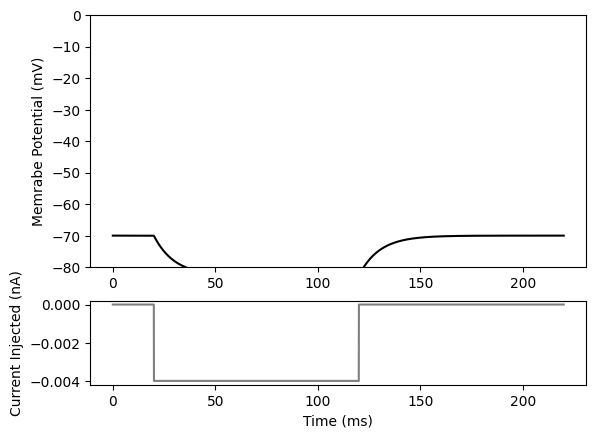

In [11]:
#@title Run the numerical simulation { run: "auto" }

n.t = 0
n.tstop = 220 # set the simulation time
n.dt = 0.025
n.v_init = -70
stim.amp = -0.004 #@param {type:"slider", min:-0.005, max:0.02, step:0.001}

n.run()



# plotting
f, (ax0, ax1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax0.plot(t,soma_v, 'k')
ax1.plot(t,stim_current, 'gray', label='I (nA)')

ax0.set_ylabel('Memrabe Potential (mV)')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Current Injected (nA)')
ax0.set_ylim([-80, 0])

# Exercise in class - I-V curve

Let's create together a new analysis and a plot: on the x-axis, we would like to represent the ampltiude of the DC current pulse we are injecting into this (1-compartmental) cell, while on the y-axis we display the response of the membrane potential. The latter is specified as the *steady-state* value that $V$ gets when $t → +∞$. Of course we don't want to run the simulation for an infinite amount of time, as we would like to go home at some point (!), but we can see that after $50-70ms$ the membrane potential reaches a *steady-state* and keeps it after that forever if the input current is indeed constant.

Thus we want to perform some elementary data analysis, extracting the points of the $V$ trace that are between $75ms$ and the time when the current stimulus is switched off, we calculate their arithmetic average (even though in this *in silico* example all the points should basically be identical), so that we end up having just one number: $V_{ss}$.

The plot we are after would then feature a series of points with $x=I_{stim}$ and $y=V_{ss}$.

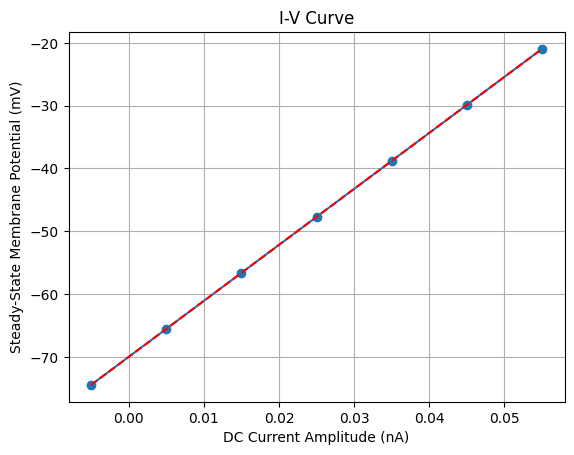

In [25]:
#@title Run the sweep { run: "auto" }

import numpy as np

minI = -0.005 #@param {type:"number"}
maxI = 0.05 #@param {type:"number"}
stepI = 0.01 #@param {type:"number"}

current_amplitudes = np.arange(minI, maxI+stepI, stepI)

steady_state_voltages = []
stim_amps = []

for amp in current_amplitudes:
    n.t = 0
    n.v_init = -70

    stim.amp = amp

    n.run()

    start_time_index = next(i for i, time in enumerate(t) if time >= stim.delay + stim.dur - 25)
    steady_state_v_trace = soma_v[start_time_index:]

    steady_state_voltage = sum(steady_state_v_trace) / len(steady_state_v_trace)

    steady_state_voltages.append(steady_state_voltage)
    stim_amps.append(amp)


# Let's fit a straight line to the points
bestfit_pars = np.polyfit(stim_amps, steady_state_voltages, 1)
bestfit_line = np.poly1d(bestfit_pars)
bestfit_xcoord = stim_amps
bestfit_ycoord = bestfit_line(stim_amps)

# Plot the I-V curve
plt.figure()
plt.plot(stim_amps, steady_state_voltages, 'o-')
plt.plot(bestfit_xcoord, bestfit_ycoord, 'r--')
plt.xlabel('DC Current Amplitude (nA)')
plt.ylabel('Steady-State Membrane Potential (mV)')
plt.title('I-V Curve')
plt.grid(True)
plt.show()